# Observational Data Collection
Grab AIA and HMI observations of the solar disk from the day of the "Great American Eclipse"

In [1]:
import os
import glob

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.time import TimeRange
from sunpy.map import Map
from astropy.coordinates import SkyCoord
import yt
import solarbextrapolation

import synthesizAR

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Downloading the data

Create a query for AIA for the day of 21 August at approximately 18:15 UTC (roughly when the Sun was most eclipsed over Houston).

In [ ]:
result_aia = Fido.search(
    a.Time(TimeRange('2017/08/20 18:15',16*u.s)),
    a.Instrument('AIA'),
    a.Wavelength(94*u.angstrom,4500*u.angstrom)
)

In [ ]:
result_aia

In [ ]:
aia_files = Fido.fetch(result_aia)

And download the HMI results as well.

In [ ]:
result_hmi = Fido.search(
    a.Time(TimeRange('2017/08/20 18:15',1*u.min)),
    a.Instrument('HMI') & a.vso.Physobs('LOS_magnetic_field'),
    #a.Wavelength(94*u.angstrom,335*u.angstrom)
)

In [ ]:
result_hmi

In [ ]:
hmi_files = Fido.fetch(result_hmi)

Or if the files have already been downloaded, just grab a list of them

In [2]:
aia_files = glob.glob('/storage-home/w/wtb2/sunpy/data/aia*2017_08_20*.fits')
hmi_files = glob.glob('/storage-home/w/wtb2/sunpy/data/hmi*2017_08_20*.fits')

## Quick Visualizations

In [3]:
aia_files = sorted(aia_files,key=lambda x:int(os.path.basename(x).split('_')[2][:-1]))

In [4]:
aia_files

['/storage-home/w/wtb2/sunpy/data/aia_lev1_94a_2017_08_20t18_15_11_12z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_131a_2017_08_20t18_15_06_62z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_171a_2017_08_20t18_15_09_35z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_193a_2017_08_20t18_15_04_84z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_211a_2017_08_20t18_15_09_63z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_304a_2017_08_20t18_15_05_13z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_335a_2017_08_20t18_15_12_64z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_335a_2017_08_20t18_15_00_63z_image_lev1.fits',
 '/storage-home/w/wtb2/sunpy/data/aia_lev1_1600a_2017_08_20t18_15_02_13z_image_lev1.fits']

In [5]:
aia_files_filtered = aia_files#aia_files[:5] + [aia_files[-2]]

In [6]:
lc = (-300*u.arcsec,-200*u.arcsec)
rc = (350*u.arcsec,350*u.arcsec)

In [ ]:
fig = plt.figure(figsize=(15,10))
for i,af in enumerate(aia_files_filtered):
    m = Map(af)
    bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
    top_right = SkyCoord(*rc,frame=m.coordinate_frame)
    m = m.submap(bottom_left,top_right)
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,annotate=False,title=False)

In [ ]:
m = Map(hmi_files[0])
m = m.rotate()

In [ ]:
bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
top_right = SkyCoord(*rc,frame=m.coordinate_frame)

In [ ]:
plt.figure(figsize=(10,10))
m = m.submap(bottom_left,top_right)
m.plot()

In [ ]:
m = Map(aia_files[-1])
bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
top_right = SkyCoord(*rc,frame=m.coordinate_frame)
plt.figure(figsize=(10,10))
m.submap(bottom_left,top_right).plot(vmin=50,vmax=1000)

## Extrapolate Field
Now, extrapolate a 3D field from the underlying magnetogram and trace some streamlines through it.

In [7]:
field = synthesizAR.Skeleton(hmi_fits_file=hmi_files[0],crop=(lc,rc),resample=u.Quantity([100,100],u.pixel))

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [ ]:
field.hmi_map.peek(vmin=-1000,vmax=1000)

In [8]:
zshape = 100
zrange = u.Quantity([0,max(u.Quantity(rc)-u.Quantity(lc)).value],u.arcsec)

In [9]:
field.extrapolate_field(zshape,zrange)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation/extrapolators/base.py:85: SunpyDeprecationWarning: This property is only 

True


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/storage-home/w/wtb2/anaconda3/envs/s

yt : [INFO     ] 2017-10-29 00:49:53,173 xlim = -13599732710.863552 25374211778.983067
yt : [INFO     ] 2017-10-29 00:49:53,174 ylim = 949280087.800446 46514724302.221939
yt : [INFO     ] 2017-10-29 00:49:53,175 xlim = -13599732710.863552 25374211778.983067
yt : [INFO     ] 2017-10-29 00:49:53,176 ylim = 949280087.800446 46514724302.221939
yt : [INFO     ] 2017-10-29 00:49:53,177 Making a fixed resolution buffer of (('stream', 'Bx')) 800 by 800
yt : [WARNING  ] 2017-10-29 00:49:53,200 Plot image for field ('stream', 'Bx') has both positive and negative values. Min = -0.003217, Max = 0.057827.
yt : [WARNING  ] 2017-10-29 00:49:53,201 Switching to symlog colorbar scaling unless linear scaling is specified later



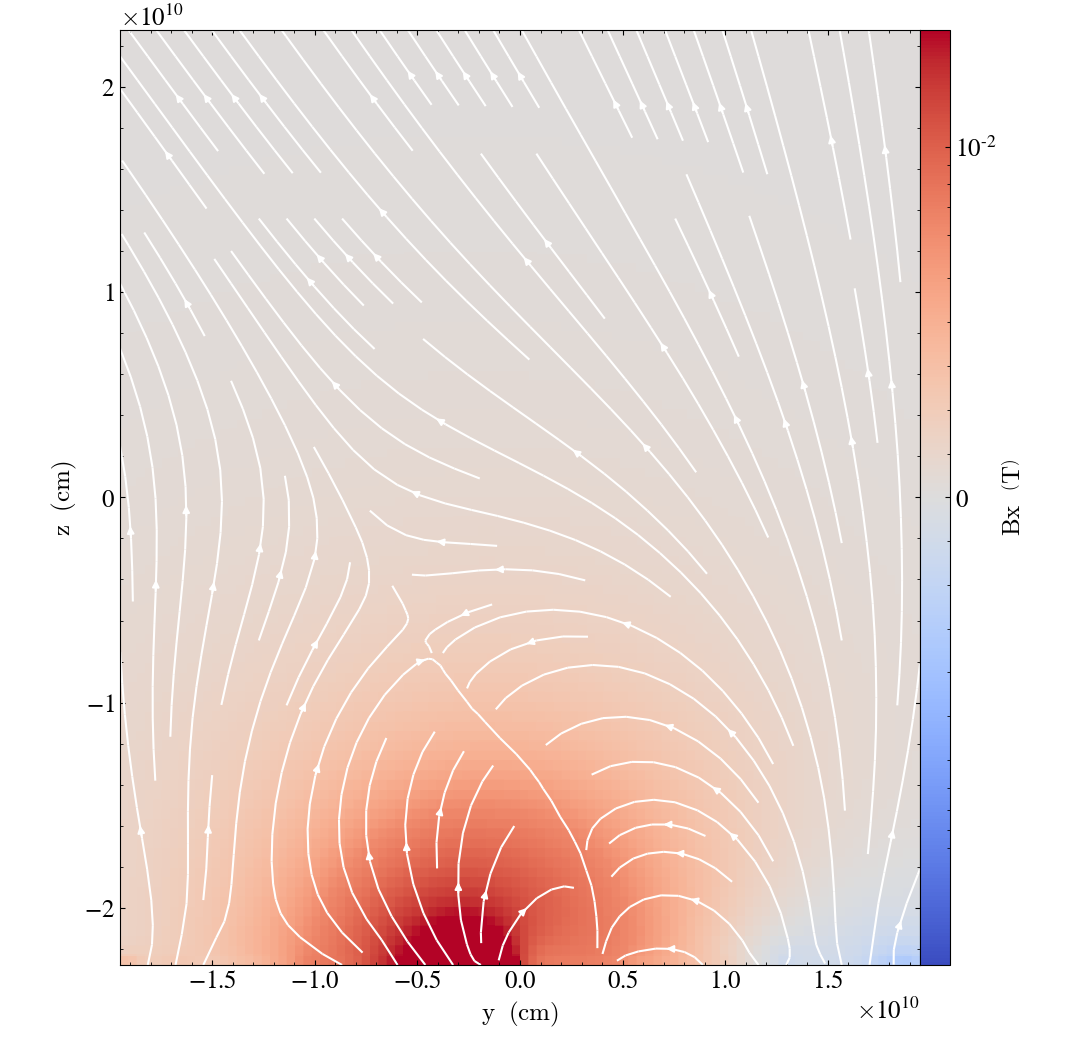

In [80]:
center = (field.extrapolated_3d_field.domain_center 
         + np.array([0,0,0])*field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(field.extrapolated_3d_field,'x','Bx',origin='center-domain',axes_unit='cm',
                 center=center)
p.annotate_streamlines('By','Bz',density=1,factor=5,plot_args={'color':'w'})
p.set_cmap('Bx','coolwarm')
p.set_zlim('Bx',-2e-2,2e-2)

In [59]:
field.extract_streamlines(10000,
                          loop_length_range=[1e9,1e11]*u.cm, 
                          close_threshold=0.05,
                          mask_threshold=0.1,
                          safety=2
                         )

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/util/util.py:69: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/util/util.py:70: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2017-10-28 20:28:15,891 AMRKDTree rebuilt, Final Volume: 8.177348e+31
Streamlining: 100%|██████████| 10000/10000 [00:18<00:00, 539.86it/s]
yt : [INFO     ] 2017-10-28 20:28:46,310 AMRKDTree rebuilt, Final Volume: 8.177348e+31
Streamlining: 100%|██████████| 2674/2674 [00:04<00:00, 538.54it/s]
yt : [INFO     ] 2017-10-28 20:28:54,190 AMRKDTree rebuilt, Final Volume: 8.177348e+

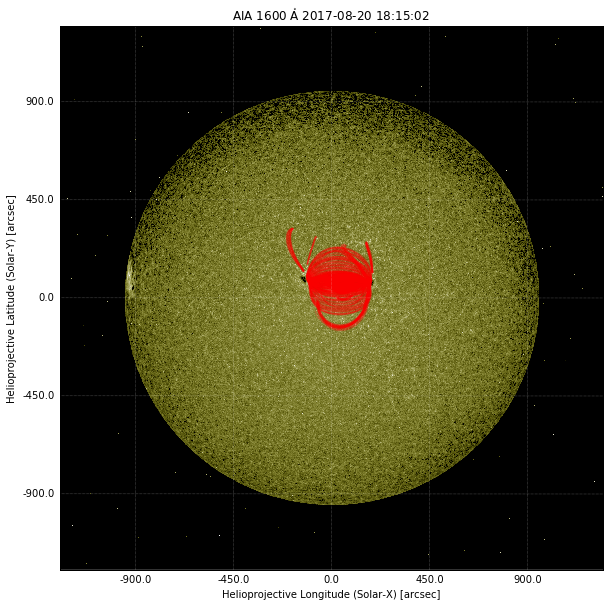

In [61]:
m = Map(aia_files[-1])
bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
top_right = SkyCoord(*rc,frame=m.coordinate_frame)
fig = plt.figure(figsize=(10,10))
sm = m#.submap(bottom_left,top_right)
ax = fig.add_subplot(111,projection=sm)
sm.plot(axes=ax,vmin=50,vmax=1000)
for stream, _ in field.streamlines[::10]:
    ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.2, color='r', transform=ax.get_transform('world'))

In [62]:
field.make_loops()

In [63]:
field.save('/storage-home/w/wtb2/data/nsci_image_contest/')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


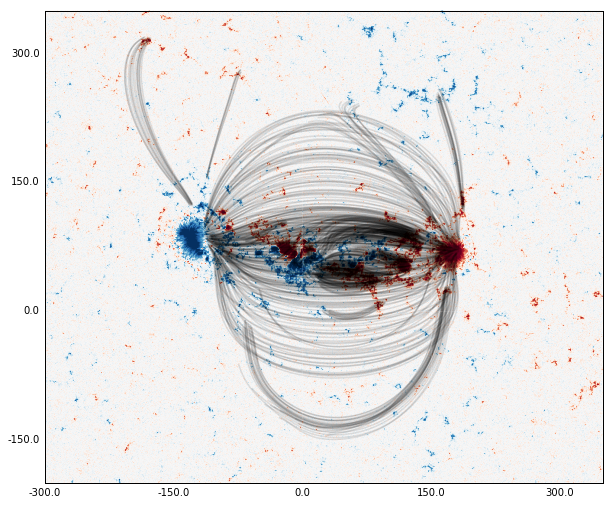

In [74]:
m = Map(hmi_files[0]).rotate()
bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
top_right = SkyCoord(*rc,frame=m.coordinate_frame)
fig = plt.figure(figsize=(10,10))
sm = m.submap(bottom_left,top_right)
ax = fig.add_subplot(111,projection=sm)
sm.plot(axes=ax,
        norm=matplotlib.colors.SymLogNorm(100,vmin=-1000,vmax=1000),
        title=False,
        annotate=False,
        cmap=plt.get_cmap('RdBu'))
for stream, _ in field.streamlines[::10]:
    ax.plot(field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.1, color='k', transform=ax.get_transform('world'))